In [1]:
import json
import numpy as np
from PIL import Image
import os
import random
from pathlib import Path
import glob

def load_coco_data(json_path):
    """Load COCO annotation file."""
    with open(json_path, 'r') as f:
        return json.load(f)

def crop_image_to_patches(image_array, patch_size=512, overlap_rate=0):
    """Crop image into patches of specified size with optional overlap."""
    patches = []
    h, w = image_array.shape
    
    # Calculate stride based on overlap rate
    stride = int(patch_size * (1 - overlap_rate))
    
    for i in range(0, h, stride):
        for j in range(0, w, stride):
            if i + patch_size <= h and j + patch_size <= w:
                patch = image_array[i:i+patch_size, j:j+patch_size]
                patches.append({
                    'patch': patch,
                    'x_offset': j,
                    'y_offset': i,
                    'patch_id': len(patches)
                })
    
    return patches

def point_in_bbox(x, y, bbox):
    """Check if point (x,y) is inside bbox [x, y, width, height]."""
    return (bbox[0] <= x <= bbox[0] + bbox[2] and 
            bbox[1] <= y <= bbox[1] + bbox[3])

def clip_segmentation_to_patch(segmentation, x_offset, y_offset, patch_size):
    """
    Clip segmentation polygon to patch boundaries and convert to patch coordinates.
    Returns None if polygon doesn't intersect patch.
    """
    # Convert flat list to coordinate pairs
    coords = [(segmentation[i] - x_offset, segmentation[i+1] - y_offset) 
              for i in range(0, len(segmentation), 2)]
    
    # Check if any point is within patch bounds
    valid_coords = []
    for x, y in coords:
        # Clip coordinates to patch boundaries
        x_clipped = max(0, min(patch_size, x))
        y_clipped = max(0, min(patch_size, y))
        valid_coords.append((x_clipped, y_clipped))
    
    # Check if polygon has meaningful area in patch
    if len(valid_coords) < 3:
        return None
    
    # Check if all points are on the boundary (degenerate polygon)
    x_coords = [c[0] for c in valid_coords]
    y_coords = [c[1] for c in valid_coords]
    
    if (all(x == 0 or x == patch_size for x in x_coords) or 
        all(y == 0 or y == patch_size for y in y_coords)):
        return None
    
    # Convert back to flat list
    return [coord for point in valid_coords for coord in point]

def get_annotations_for_patch(annotations, x_offset, y_offset, patch_size):
    """Get annotations that intersect with the patch."""
    patch_annotations = []
    
    for ann in annotations:
        bbox = ann['bbox']
        
        # Check if bbox intersects with patch
        bbox_right = bbox[0] + bbox[2]
        bbox_bottom = bbox[1] + bbox[3]
        patch_right = x_offset + patch_size
        patch_bottom = y_offset + patch_size
        
        # Check intersection
        if not (bbox_right < x_offset or bbox[0] > patch_right or
                bbox_bottom < y_offset or bbox[1] > patch_bottom):
            
            # Process each segmentation polygon
            new_segmentations = []
            for seg in ann['segmentation']:
                clipped_seg = clip_segmentation_to_patch(seg, x_offset, y_offset, patch_size)
                if clipped_seg:
                    new_segmentations.append(clipped_seg)
            
            # Only include annotation if it has valid segmentations
            if new_segmentations:
                # Adjust bbox to patch coordinates
                new_bbox = [
                    max(0, bbox[0] - x_offset),
                    max(0, bbox[1] - y_offset),
                    min(bbox[2], patch_right - bbox[0]),
                    min(bbox[3], patch_bottom - bbox[1])
                ]
                
                # Create new annotation
                new_ann = ann.copy()
                new_ann['bbox'] = new_bbox
                new_ann['segmentation'] = new_segmentations
                
                # Calculate new area (approximate)
                new_ann['area'] = new_bbox[2] * new_bbox[3]
                
                patch_annotations.append(new_ann)
    
    return patch_annotations

def create_coco_annotation(image_info_list, annotations_list, categories):
    """Create COCO format annotation dictionary."""
    return {
        'images': image_info_list,
        'annotations': annotations_list,
        'categories': categories
    }

def process_single_file(tiff_path, json_path, base_name, train_dir, test_dir, 
                       patch_size, overlap_rate, train_patches_list, test_patches_list,
                       image_id_counter, annotation_id_counter, categories):
    """
    Process a single TIFF/JSON pair and add to train/test lists.
    Returns updated counters.
    """
    print(f"\nProcessing {base_name}...")
    
    # Load image and annotations
    img = Image.open(tiff_path)
    img_array = np.array(img)
    coco_data = load_coco_data(json_path)
    
    # Use categories from first file, or update if needed
    if not categories:
        categories.extend(coco_data['categories'])
    
    print(f"  Image size: {img_array.shape}")
    
    # Crop into patches
    patches = crop_image_to_patches(img_array, patch_size, overlap_rate)
    print(f"  Created {len(patches)} patches")
    
    # Randomly split patches for this file
    random.shuffle(patches)
    train_count = int(len(patches) * 0.8)
    
    # Process train patches
    for patch_info in patches[:train_count]:
        train_patches_list.append({
            'patch_info': patch_info,
            'base_name': base_name,
            'annotations': coco_data['annotations'],
            'tiff_path': tiff_path
        })
    
    # Process test patches
    for patch_info in patches[train_count:]:
        test_patches_list.append({
            'patch_info': patch_info,
            'base_name': base_name,
            'annotations': coco_data['annotations'],
            'tiff_path': tiff_path
        })
    
    return len(patches[:train_count]), len(patches[train_count:])

def save_patches_and_annotations(patches_list, output_dir, split_name, patch_size):
    """Save patches and create COCO annotations for a split."""
    images = []
    annotations = []
    image_id = 1
    annotation_id = 1
    
    print(f"\nSaving {split_name} patches...")
    for idx, patch_data in enumerate(patches_list):
        patch_info = patch_data['patch_info']
        base_name = patch_data['base_name']
        
        # Create filename with base name and patch ID
        image_filename = f"{base_name}_patch_{patch_info['patch_id']:03d}.tif"
        image_path = output_dir / image_filename
        
        # Save patch image
        Image.fromarray(patch_info['patch']).save(image_path)
        
        # Create image info
        image_info = {
            'id': image_id,
            'file_name': image_filename,
            'width': patch_size,
            'height': patch_size,
            'source_file': base_name
        }
        images.append(image_info)
        
        # Get annotations for this patch
        patch_anns = get_annotations_for_patch(
            patch_data['annotations'],
            patch_info['x_offset'],
            patch_info['y_offset'],
            patch_size
        )
        
        # Update annotation IDs and image IDs
        for ann in patch_anns:
            ann['id'] = annotation_id
            ann['image_id'] = image_id
            annotations.append(ann)
            annotation_id += 1
        
        image_id += 1
        
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(patches_list)} patches")
    
    return images, annotations

def process_all_files(tiff_dir='./results/tiff', json_dir='./results/json',
                     output_dir='plants_coco', patch_size=640, overlap_rate=0, train_ratio=0.8):
    """
    Process all TIFF and JSON file pairs in the specified directories.
    """
    # Create directory structure
    output_path = Path(output_dir)
    train_dir = output_path / 'images' / 'train'
    test_dir = output_path / 'images' / 'test'
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Find all TIFF files (both .tif and .tiff extensions)
    tiff_files = sorted(glob.glob(os.path.join(tiff_dir, '*.tif')) + 
                       glob.glob(os.path.join(tiff_dir, '*.tiff')))
    print(f"Found {len(tiff_files)} TIFF files in {tiff_dir}")
    
    if not tiff_files:
        print(f"No TIFF files found in {tiff_dir}")
        print(f"Please check that the directory exists and contains .tif or .tiff files")
        return
    
    # Lists to collect all patches
    train_patches_list = []
    test_patches_list = []
    categories = []
    
    # Process each file
    for tiff_path in tiff_files:
        # Get base name (without extension)
        base_name = Path(tiff_path).stem
        
        # Construct corresponding JSON path
        json_path = os.path.join(json_dir, f"{base_name}.json")
        
        # Check if JSON file exists
        if not os.path.exists(json_path):
            print(f"Warning: JSON file not found for {base_name}, skipping...")
            continue
        
        # Process this file pair
        train_count, test_count = process_single_file(
            tiff_path, json_path, base_name, train_dir, test_dir,
            patch_size, overlap_rate, train_patches_list, test_patches_list,
            0, 0, categories
        )
    
    print(f"\n{'='*60}")
    print(f"Total patches collected:")
    print(f"  Train: {len(train_patches_list)}")
    print(f"  Test: {len(test_patches_list)}")
    print(f"{'='*60}")
    
    # Save train patches and create annotations
    train_images, train_annotations = save_patches_and_annotations(
        train_patches_list, train_dir, 'train', patch_size
    )
    
    # Save test patches and create annotations
    test_images, test_annotations = save_patches_and_annotations(
        test_patches_list, test_dir, 'test', patch_size
    )
    
    # Create COCO annotation files
    train_coco = create_coco_annotation(train_images, train_annotations, categories)
    test_coco = create_coco_annotation(test_images, test_annotations, categories)
    
    # Save annotation files in their respective directories
    train_json_path = train_dir / 'train_annotations.json'
    test_json_path = test_dir / 'test_annotations.json'
    
    with open(train_json_path, 'w') as f:
        json.dump(train_coco, f, indent=2)
    
    with open(test_json_path, 'w') as f:
        json.dump(test_coco, f, indent=2)
    
    # Print final summary
    print(f"\n{'='*60}")
    print("PROCESSING COMPLETE")
    print(f"{'='*60}")
    print(f"\nTrain set:")
    print(f"  Images: {len(train_images)}")
    print(f"  Annotations: {len(train_annotations)}")
    print(f"  Saved to: {train_dir}")
    
    print(f"\nTest set:")
    print(f"  Images: {len(test_images)}")
    print(f"  Annotations: {len(test_annotations)}")
    print(f"  Saved to: {test_dir}")
    
    print(f"\nAnnotation files:")
    print(f"  Train: {train_json_path}")
    print(f"  Test: {test_json_path}")

# Usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    
    process_all_files(
        tiff_dir='./data/images',
        json_dir='./data/coco',
        output_dir='./result/plants_coco_p640_o25_20tiff',
        patch_size=640,
        overlap_rate=0.25,  # Change to 0.25 for 25% overlap, 0.5 for 50% overlap
        train_ratio=0.8
    )

Found 20 TIFF files in ./data/images

Processing 20211222_094342_petiole_test_00100...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_094342_petiole_test_00200...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_094342_petiole_test_00300...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_094342_petiole_test_00400...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_094342_petiole_test_00500...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_104840_petiole_test2_00100...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_104840_petiole_test2_00200...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_104840_petiole_test2_00300...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_104840_petiole_test2_00400...
  Image size: (2560, 2560)
  Created 25 patches

Processing 20211222_104840_petiole_test2_00500...
  Image size: (2560, 2560)


VERIFYING COCO DATASET (RANDOM SAMPLING)

############################################################
# TRAIN SET VERIFICATION
############################################################

Loading TRAIN set from: result/plants_coco_p640_o25_20tiff/images/train

Dataset Statistics:
  Total images: 400
  Total annotations: 59797

  Annotations per class:
    Cortex: 35504
    Phloem Fibers: 1356
    Phloem: 101
    Xylem vessels: 13782
    Air-based Pith cells: 1182
    Water-based Pith cells: 7872

  Randomly selected 6 patches for visualization

Processing 20211222_125057_petiole4_00200_patch_005.tif...
  Found 232 annotations

Processing 20211222_094342_petiole_test_00300_patch_002.tif...
  Found 220 annotations

Processing 20211222_094342_petiole_test_00100_patch_001.tif...
  Found 159 annotations

Processing 20211222_125057_petiole4_00400_patch_024.tif...
  Found 27 annotations

Processing 20211222_104840_petiole_test2_00300_patch_000.tif...
  Found 111 annotations

Processing 202

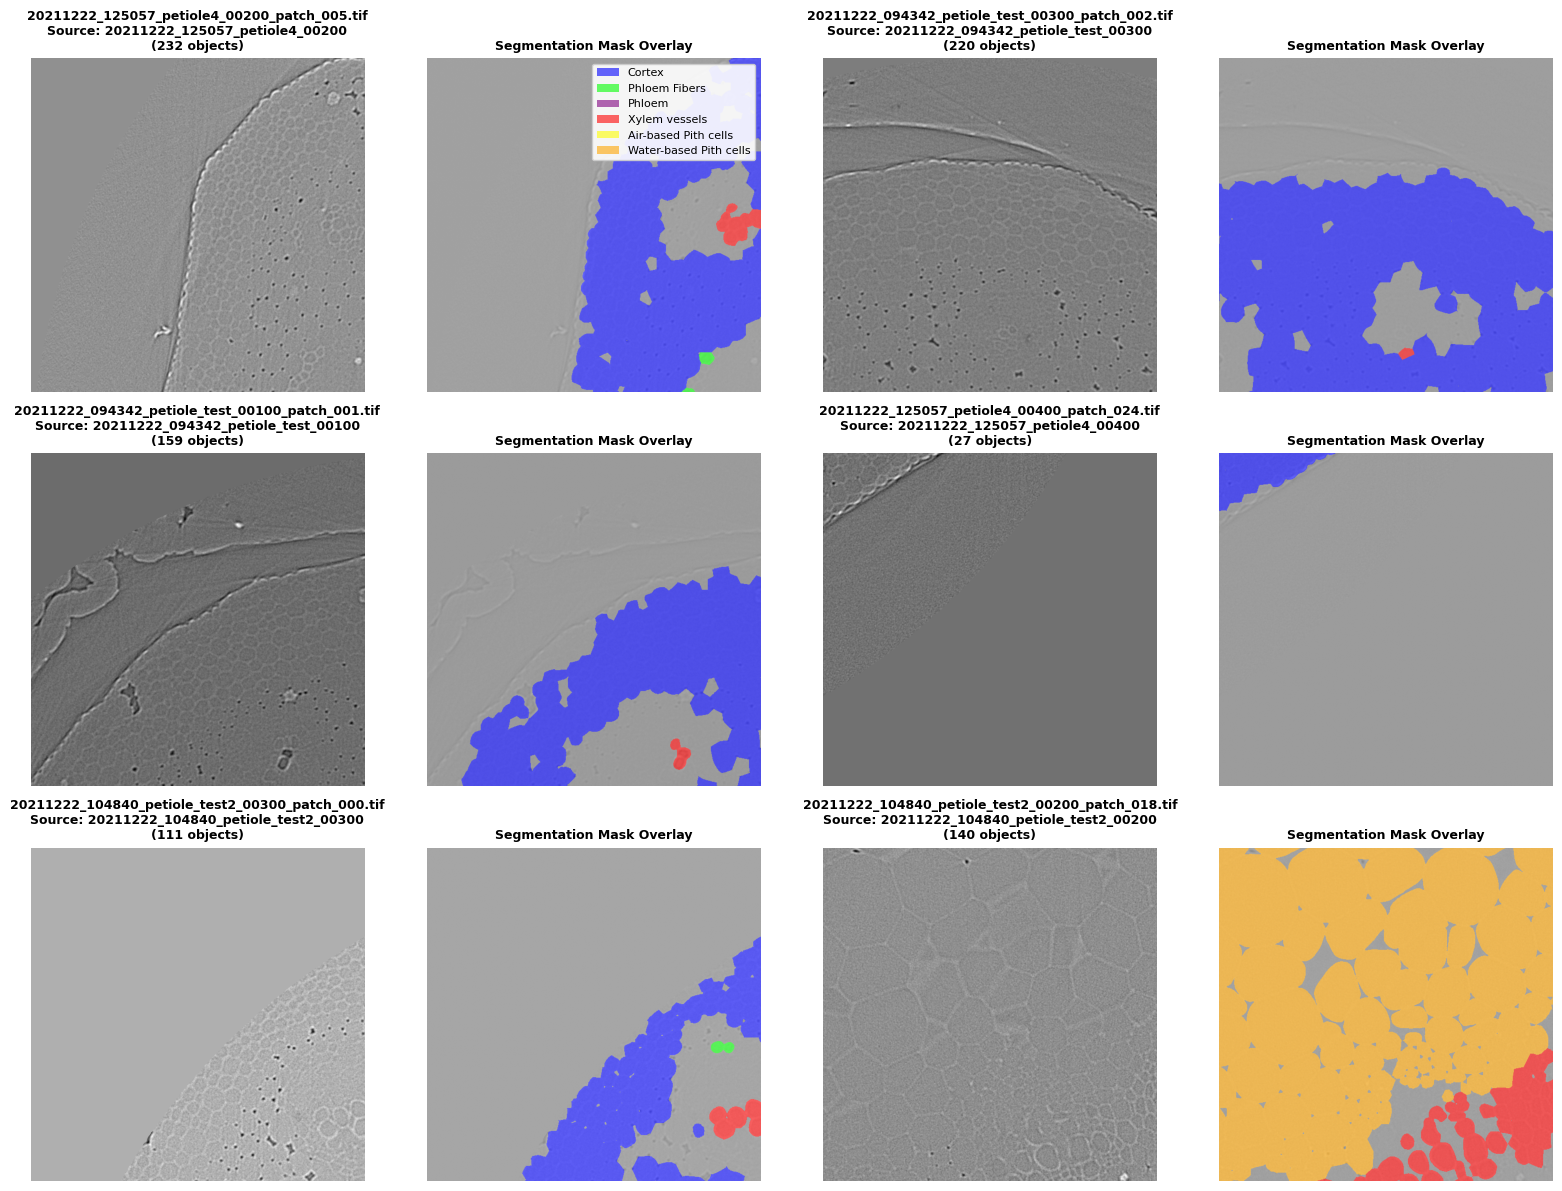


############################################################
# TEST SET VERIFICATION
############################################################

Loading TEST set from: result/plants_coco_p640_o25_20tiff/images/test

Dataset Statistics:
  Total images: 100
  Total annotations: 15013

  Annotations per class:
    Cortex: 7486
    Phloem Fibers: 392
    Phloem: 41
    Xylem vessels: 4165
    Air-based Pith cells: 339
    Water-based Pith cells: 2590

  Randomly selected 6 patches for visualization

Processing 20211222_125057_petiole4_00200_patch_024.tif...
  Found 12 annotations

Processing 20211222_094342_petiole_test_00300_patch_017.tif...
  Found 87 annotations

Processing 20211222_094342_petiole_test_00100_patch_003.tif...
  Found 120 annotations

Processing 20211222_125057_petiole4_00400_patch_007.tif...
  Found 234 annotations

Processing 20211222_104840_petiole_test2_00300_patch_021.tif...
  Found 243 annotations

Processing 20211222_104840_petiole_test2_00200_patch_008.tif...
 

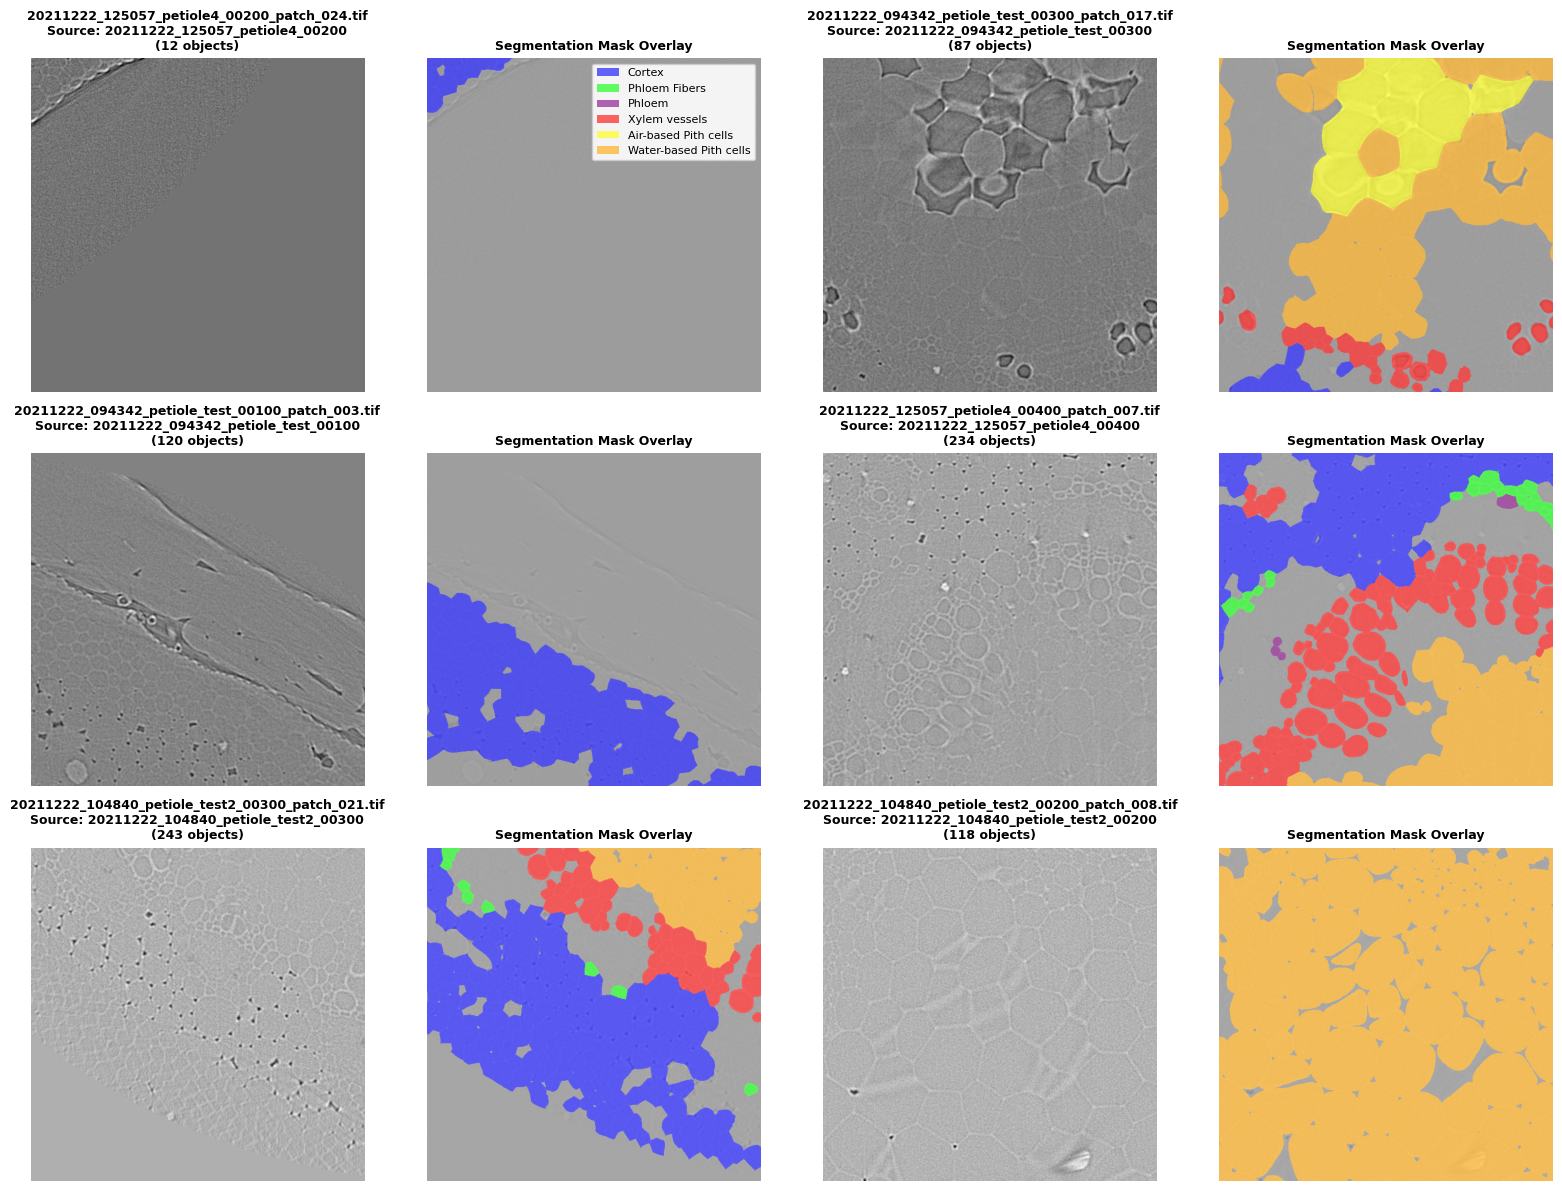


VERIFICATION COMPLETE!


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import random

def load_coco_data(json_path):
    """Load COCO annotation file."""
    with open(json_path, 'r') as f:
        return json.load(f)

def normalize_image(img_array):
    """Normalize image to 0-1 range for display."""
    img_min = img_array.min()
    img_max = img_array.max()
    if img_max > img_min:
        return (img_array - img_min) / (img_max - img_min)
    return img_array

def create_segmentation_mask(segmentation, img_shape, value):
    """Create a mask from segmentation polygon."""
    mask = Image.new('L', (img_shape[1], img_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    
    coords = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
    draw.polygon(coords, fill=value)
    
    return np.array(mask)

def visualize_random_patches(data_dir, split='train', num_samples=6, seed=None):
    """
    Randomly select and visualize patches with their mask overlays.
    
    Args:
        data_dir: Root directory (e.g., 'plants_coco_640')
        split: 'train' or 'test'
        num_samples: Number of random patches to visualize
        seed: Random seed for reproducibility
    """
    if seed is not None:
        random.seed(seed)
    
    # Define paths
    data_path = Path(data_dir) / 'images' / split
    json_path = data_path / f'{split}_annotations.json'
    
    # Check if files exist
    if not data_path.exists():
        print(f"Error: Directory not found: {data_path}")
        return
    
    if not json_path.exists():
        print(f"Error: Annotation file not found: {json_path}")
        return
    
    # Load annotations
    print(f"\n{'='*60}")
    print(f"Loading {split.upper()} set from: {data_path}")
    print(f"{'='*60}")
    
    coco_data = load_coco_data(json_path)
    
    # Extract info
    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Print statistics
    print(f"\nDataset Statistics:")
    print(f"  Total images: {len(images)}")
    print(f"  Total annotations: {len(annotations)}")
    
    # Count annotations per class
    class_counts = {}
    for ann in annotations:
        cat_id = ann['category_id']
        class_counts[cat_id] = class_counts.get(cat_id, 0) + 1
    
    print(f"\n  Annotations per class:")
    for cat_id in sorted(class_counts.keys(), key=str):
        print(f"    {categories[cat_id]}: {class_counts[cat_id]}")
    
    # Randomly select sample images
    num_samples = min(num_samples, len(images))
    sample_images = random.sample(images, num_samples)
    print(f"\n  Randomly selected {num_samples} patches for visualization")
    
    # Define colors for classes (RGB format: 0-255)
    class_colors = {
        0: [128, 128, 128],  # Gray - Background
        1: [0, 0, 255],      # Blue - Cortex
        2: [0, 255, 0],      # Green - Phloem Fibers
        3: [128, 0, 128],    # Purple - Phloem
        4: [255, 0, 0],      # Red - Xylem vessels
        5: [255, 255, 0],    # Yellow - Air-based Pith cells
        6: [255, 165, 0],    # Orange - Water-based Pith cells
    }
    
    # Convert RGB (0-255) to normalized RGB (0-1) with alpha for matplotlib
    class_colors_rgba = {}
    for cat_id, rgb in class_colors.items():
        class_colors_rgba[cat_id] = [rgb[0]/255.0, rgb[1]/255.0, rgb[2]/255.0, 0.6]
    
    # Create visualization - 2 columns (original + overlay)
    rows = (num_samples + 1) // 2
    fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))
    
    # Flatten axes for easier indexing
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, img_info in enumerate(sample_images):
        row = idx // 2
        col_offset = (idx % 2) * 2
        
        print(f"\nProcessing {img_info['file_name']}...")
        
        # Load image
        img_path = data_path / img_info['file_name']
        if not img_path.exists():
            print(f"  Warning: Image file not found: {img_path}")
            continue
            
        img = Image.open(img_path)
        img_array = np.array(img)
        img_normalized = normalize_image(img_array)
        
        # Get annotations for this image
        img_annotations = [ann for ann in annotations if ann['image_id'] == img_info['id']]
        print(f"  Found {len(img_annotations)} annotations")
        
        # Get source file info if available
        source_info = img_info.get('source_file', 'unknown')
        
        # 1. Original image
        axes[row, col_offset].imshow(img_normalized, cmap='gray')
        axes[row, col_offset].set_title(
            f"{img_info['file_name']}\nSource: {source_info}\n({len(img_annotations)} objects)", 
            fontsize=9, fontweight='bold'
        )
        axes[row, col_offset].axis('off')
        
        # 2. Mask overlay
        axes[row, col_offset + 1].imshow(img_normalized, cmap='gray', alpha=0.4)
        
        # Create colored overlay
        class_mask = np.zeros(img_array.shape, dtype=np.uint8)
        for ann in img_annotations:
            for segmentation in ann['segmentation']:
                category_id = ann['category_id']
                seg_mask = create_segmentation_mask(segmentation, img_array.shape, category_id)
                class_mask = np.maximum(class_mask, seg_mask)
        
        # Create RGBA overlay
        class_overlay_rgba = np.zeros((*img_array.shape, 4))
        for cat_id, color in class_colors_rgba.items():
            mask_region = class_mask == cat_id
            for c in range(4):
                class_overlay_rgba[:, :, c][mask_region] = color[c]
        
        axes[row, col_offset + 1].imshow(class_overlay_rgba)
        axes[row, col_offset + 1].set_title('Segmentation Mask Overlay', fontsize=9, fontweight='bold')
        axes[row, col_offset + 1].axis('off')
        
        # Add legend to first overlay (exclude background class 0)
        if idx == 0:
            legend_elements = [
                mpatches.Patch(
                    facecolor=[class_colors[i][0]/255.0, class_colors[i][1]/255.0, class_colors[i][2]/255.0], 
                    label=categories[i],
                    alpha=0.6
                ) 
                for i in sorted(categories.keys(), key=str) if i != 0  # Exclude background
            ]
            axes[row, col_offset + 1].legend(
                handles=legend_elements, 
                loc='upper right', 
                fontsize=8,
                framealpha=0.9
            )
    
    # Hide any unused subplots
    total_subplots = rows * 4
    used_subplots = num_samples * 2
    for i in range(used_subplots, total_subplots):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')
    
    plt.tight_layout()
    output_path = f'{split}_random_samples_{num_samples}.png'
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"\n{'='*60}")
    print(f"Visualization saved as '{output_path}'")
    print(f"{'='*60}")
    plt.show()

def verify_dataset_random(data_dir='plants_coco_640', num_samples_per_split=6, seed=42):
    """Randomly verify both train and test datasets."""
    
    print("\n" + "="*60)
    print("VERIFYING COCO DATASET (RANDOM SAMPLING)")
    print("="*60)
    
    # Verify train set
    print("\n" + "#"*60)
    print("# TRAIN SET VERIFICATION")
    print("#"*60)
    visualize_random_patches(data_dir, split='train', num_samples=num_samples_per_split, seed=seed)
    
    # Verify test set
    print("\n" + "#"*60)
    print("# TEST SET VERIFICATION")
    print("#"*60)
    visualize_random_patches(data_dir, split='test', num_samples=num_samples_per_split, seed=seed)
    
    print("\n" + "="*60)
    print("VERIFICATION COMPLETE!")
    print("="*60)

# Usage
if __name__ == "__main__":
    # Random seed for reproducibility (set to None for different samples each time)
    verify_dataset_random(
        data_dir='./result/plants_coco_p640_o25_20tiff',
        num_samples_per_split=6,
        seed=42  # Change or set to None for different random samples
    )